In [20]:
from __future__ import print_function, division
from builtins import range
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter

In [19]:
def print_values(V,g):
    for i in range(g.width):
        print('------------------------------------------------------------')
        for j in range(g.height):
            v=V.get((i,j),0)
            if v>=0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="")
        print('')

def print_policy(P,g):
    for i in range(g.width):
        print('-------------------------------------------------------------')
        for j in range(g.height):
            a=P.get((i,j),' ')
            print("  %s  |" % a, end="")
        print('')
        
def max_dict(d):
    max_key=None
    max_val=float('-inf')
    for k,v in d.itmes():
        if v>max_val:
            max_val=v
            max_key=k
    return max_key, max_val

In [2]:
class Grid: # Environment
  def __init__(self, width, height, start):
    # i is vertical axis, j is horizontal
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]
    self.start=start

  def set(self, rewards, actions, obey_prob):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions
    self.obey_prob = obey_prob

  def non_terminal_states(self):
    return self.actions.keys()

  def terminal_states(self):
    return [x for x in self.rewards.keys() if x not in self.actions.keys()]

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def stochastic_move(self, action):
    p = np.random.random()
    if p <= self.obey_prob:
      return action
    if action == 'U' or action == 'D':
      return np.random.choice(['L', 'R'])
    elif action == 'L' or action == 'R':
      return np.random.choice(['U', 'D'])

  def move(self, action):
    actual_action = self.stochastic_move(action)
    if actual_action in self.actions[(self.i, self.j)]:
      if actual_action == 'U':
        self.i -= 1
      elif actual_action == 'D':
        self.i += 1
      elif actual_action == 'R':
        self.j += 1
      elif actual_action == 'L':
        self.j -= 1
    return self.rewards.get((self.i, self.j), 0)

  def step(self,action):
    actual_action=self.stochastic_move(action)
    new_state=[self.i,self.j]
    if actual_action in self.actions[(self.i, self.j)]:
      if actual_action == 'U':
        new_state[0] -= 1
      elif actual_action == 'D':
        new_state[0] += 1
      elif actual_action == 'R':
        new_state[1] += 1
      elif actual_action == 'L':
        new_state[1] -= 1
    new_state=tuple(new_state)
    reward=self.rewards[new_state]
    done=self.is_terminal(new_state)
    return new_state,reward,done
            

  def check_move(self, action):
    i = self.i
    j = self.j
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        i -= 1
      elif action == 'D':
        i += 1
      elif action == 'R':
        j += 1
      elif action == 'L':
        j -= 1
    # return a reward (if any)
    return (i,j)

  def get_transition_probs(self, action):
    # returns a list of (probability, reward, s') transition tuples
    probs = []
    state = self.check_move(action)
    probs.append((self.obey_prob, state))
    disobey_prob = 1 - self.obey_prob
    if not (disobey_prob > 0.0):
      return probs
    if action == 'U' or action == 'D':
      state = self.check_move('L')
      probs.append((disobey_prob / 2, state))
      state = self.check_move('R')
      probs.append((disobey_prob / 2, state))
    elif action == 'L' or action == 'R':
      state = self.check_move('U')
      probs.append((disobey_prob / 2, state))
      state = self.check_move('D')
      probs.append((disobey_prob / 2, state))
    return probs

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid(obey_prob=1.0, step_cost=None):
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  # the grid looks like this
  # x means you can't go there
  # s means start position
  # number means reward at that state
  # .  .  .  1
  # .  x  . -1
  # s  .  .  .
  # obey_brob (float): the probability of obeying the command
  # step_cost (float): a penalty applied each step to minimize the number of moves (-0.1)
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions, obey_prob)
  if step_cost is not None:
    g.rewards.update({
      (0, 0): step_cost,
      (0, 1): step_cost,
      (0, 2): step_cost,
      (1, 0): step_cost,
      (1, 2): step_cost,
      (2, 0): step_cost,
      (2, 1): step_cost,
      (2, 2): step_cost,
      (2, 3): step_cost,
    })
  return g

In [42]:
num_episodes=10000
max_steps_per_episode=1000

learning_rate=0.1
discount_rate=0.9

exploration_rate=1
max_exploration_rate=1
min_exploration_rate=0.01
exploration_decay_rate=0.001


In [43]:
grid=standard_grid(obey_prob=0.8, step_cost=-0.1)
q_table={}
for i in grid.actions.keys():
    q_table.update({
            i:{}
        })
for i in grid.actions.keys():
    for j in grid.actions[i]:
        q_table[i].update({
            j:0
        })
        
rewards_all_episodes=[]
Steps=[]
for episode in range(num_episodes):
    grid.set_state(grid.start)
    state=(grid.i,grid.j)
    done=False
    rewards_current_episode=0
    for step in range(max_steps_per_episode):
        exploration_rate_shreshold=random.uniform(0,1)
        if exploration_rate_shreshold>exploration_rate:
            max_reward=float('-inf')
            for i in q_table[state].keys():
                if q_table[state][i]>max_reward:
                    max_reward=q_table[state][i]
                    action=i
        else:
            action=random.sample(grid.actions[state],1)[0]
        
        new_state,reward,done=grid.step(action)    
        
        if done==True:
            q_table[state][action]=q_table[state][action]*(1-learning_rate)+\
               learning_rate*(reward)
        
        else:
            q_table[state][action]=q_table[state][action]*(1-learning_rate)+\
               learning_rate*(reward+discount_rate*max(q_table[new_state].values()))

        state=new_state
        grid.set_state(state)
        rewards_current_episode+=reward

        if done ==True:
            break
    Steps.append(step)
    exploration_rate=min_exploration_rate+(max_exploration_rate - min_exploration_rate) *\
                        np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)

In [50]:
sum(Steps[-1000:])/len(Steps[-1000:])

5.381

In [175]:
rewards_per_thousand_episodes=np.split(np.array(rewards_all_episodes),num_episodes/1000)
count=1000
rewards_thousand_episodes=[]
for r in rewards_per_thousand_episodes:
    rewards_thousand_episodes.append(sum(r/1000))
    print(count,": ",str(sum(r/1000)))
    count+=1000

1000 :  -0.7982000000000002
2000 :  0.11880000000000034
3000 :  0.31079999999999935
4000 :  0.38749999999999957
5000 :  0.35689999999999933
6000 :  0.41649999999999854
7000 :  0.3960999999999988
8000 :  0.3805999999999989
9000 :  0.39569999999999866
10000 :  0.39419999999999933


In [158]:
policy={}
for i in q_table.keys():
    max_q=float('-inf')
    for j in q_table[i].keys():
        if q_table[i][j]>max_q:
            max_q=q_table[i][j]
            policy.update({
                i:j
            })

In [159]:
    print('Policy (Q LEARNING Results):')
    print_policy(policy,grid)

Policy (Q LEARNING Results):
-------------------------------------------------------------
  R  |  R  |  R  |     |
-------------------------------------------------------------
  U  |     |  U  |     |
-------------------------------------------------------------
  U  |  R  |  U  |  L  |


In [9]:
def huge_grid(obey_prob=1.0, step_cost=None):

  g = Grid(10, 10, (9, 0))
  rewards = {(1, 9): 1, (2, 9): -1,(4,2):-0.2, (5,5):0.2}
  actions = {
      (0,0): ('R','D'),
      (0,9): ('L','D'),
      (9,0): ('R','U'),
      (9,9): ('L','U'),
  }
  for j in range(1,9):
      actions[(0,j)]=('L','R','D')
      actions[(9,j)]=('L','R','U')
  for i in range(1,9):
      actions[(i,0)]=('R','U','D')
  for i in range(3,9):
      actions[(i,9)]=('L','U','D')
  for i in range(1,9):
    for j in range(1,9):
        actions[(i,j)]=('L','R','U','D')
  actions.update({
      (6,4): ('L','U','D'),
      (5,5): ('L','R','U'),
      (6,6): ('R','U','D'),
      (7,5): ('L','R','D'),
      (7,1): ('L','U','D'),
      (6,2): ('L','R','U'),
      (7,3): ('R','U','D'),
      (8,2): (('L','R','D'))       
  })
  del actions[(6,5)]
  del actions[(7,2)]
  
  g.set(rewards, actions, obey_prob)
  if step_cost is not None:
        for i in range(0,10):
            for j in range(0,10):
                if (i,j) not in g.rewards.keys():
                    g.rewards.update({
                        (i,j): step_cost
                    })
  return g

In [28]:
grid=huge_grid(obey_prob=0.8, step_cost=-0.03)
q_table={}
for i in grid.actions.keys():
    q_table.update({
            i:{}
        })
for i in grid.actions.keys():
    for j in grid.actions[i]:
        q_table[i].update({
            j:0
        })
        
rewards_all_episodes=[]
for episode in range(num_episodes):
    grid.set_state(grid.start)
    state=(grid.i,grid.j)
    done=False
    rewards_current_episode=0
    for step in range(max_steps_per_episode):
        exploration_rate_shreshold=random.uniform(0,1)
        if exploration_rate_shreshold>exploration_rate:
            max_reward=float('-inf')
            for i in q_table[state].keys():
                if q_table[state][i]>max_reward:
                    max_reward=q_table[state][i]
                    action=i
        else:
            action=random.sample(grid.actions[state],1)[0]
        
        new_state,reward,done=grid.step(action)    
        
        if done==True:
            q_table[state][action]=q_table[state][action]*(1-learning_rate)+\
               learning_rate*(reward)
        
        else:
            q_table[state][action]=q_table[state][action]*(1-learning_rate)+\
               learning_rate*(reward+discount_rate*max(q_table[new_state].values()))

        state=new_state
        grid.set_state(state)
        rewards_current_episode+=reward

        if done ==True:
            break
    
    exploration_rate=min_exploration_rate+(max_exploration_rate - min_exploration_rate) *\
                        np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)

In [181]:
rewards_per_thousand_episodes=np.split(np.array(rewards_all_episodes),num_episodes/1000)
count=1000
rewards_thousand_episodes=[]
for r in rewards_per_thousand_episodes:
    rewards_thousand_episodes.append(sum(r/1000))
    print(count,": ",str(sum(r/1000)))
    count+=1000

1000 :  -0.7532199999999982
2000 :  17.800919999999923
3000 :  38.299079999999876
4000 :  46.256870000000006
5000 :  50.11518
6000 :  52.695600000000034
7000 :  52.33926999999996
8000 :  50.698279999999855
9000 :  51.51677000000006
10000 :  52.20724000000002


In [29]:
policy={}
for i in q_table.keys():
    max_q=float('-inf')
    for j in q_table[i].keys():
        if q_table[i][j]>max_q:
            max_q=q_table[i][j]
            policy.update({
                i:j
            })

In [183]:
    print('Policy (Q LEARNING Results):')
    print_policy(policy,grid)

Policy (Q LEARNING Results):
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  D  |
-------------------------------------------------------------
  D  |  D  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |     |
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  R  |  R  |  U  |  U  |  L  |     |
-------------------------------------------------------------
  R  |  D  |  R  |  R  |  D  |  D  |  D  |  U  |  U  |  L  |
-------------------------------------------------------------
  D  |  D  |  R  |  R  |  R  |  D  |  L  |  L  |  L  |  L  |
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  R  |  L  |  L  |  L  |  L  |  L  |
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  U  |     |  U  |  L  |  U  |  L  |
-------------------------------------------------------------
  U  |  U  |     |  U  |  U  |  L  |  U  |  L  |

In [184]:
episodes=[1,2,3,4,5,6,7,8,9,10]


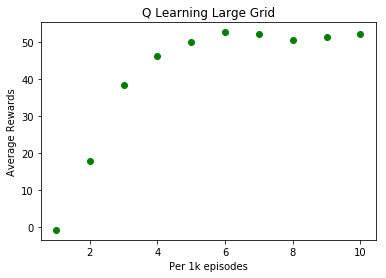

In [185]:
plt.plot(episodes,rewards_thousand_episodes,'go')
plt.ylabel('Average Rewards')
plt.xlabel('Per 1k episodes')
plt.title('Q Learning Large Grid')
plt.savefig('E:/Machine Learning/HW4/QL_LG.png')

In [32]:
num_episodes=100
max_steps=1000
rewards=[]
final_states=[]
for episode in range(num_episodes):
    grid.set_state(grid.start)
    state=(grid.i,grid.j)
    done=False
    rewards_current_episode=0
    for step in range(max_steps):
        action=policy[state]
        new_state,reward,done=grid.step(action)    
        state=new_state
        grid.set_state(state)
        rewards_current_episode+=reward
        if done ==True:
            break
    rewards.append(rewards_current_episode)
    final_states.append(state)

In [33]:
sum(rewards)/100

51.13199999999999

In [10]:
grid=huge_grid(obey_prob=0.8, step_cost=-0.03)
q_table={}
Steps=[]
for i in grid.actions.keys():
    q_table.update({
            i:{}
        })
for i in grid.actions.keys():
    for j in grid.actions[i]:
        q_table[i].update({
            j:0
        })
        
rewards_all_episodes=[]
for episode in range(num_episodes):
    grid.set_state(grid.start)
    state=(grid.i,grid.j)
    done=False
    rewards_current_episode=0
    for step in range(max_steps_per_episode):
        possible_actions=grid.actions[state]
        sum_exp=sum(np.exp(list(q_table[state].values())))
        probability_action=[]
        for a in possible_actions:
            probability_action.append(np.exp(q_table[state][a])/sum_exp)
        action=random.choices(possible_actions, probability_action)[0]  
        new_state,reward,done=grid.step(action)    
        
        if done==True:
            q_table[state][action]=q_table[state][action]*(1-learning_rate)+\
               learning_rate*(reward)
        
        else:
            q_table[state][action]=q_table[state][action]*(1-learning_rate)+\
               learning_rate*(reward+discount_rate*max(q_table[new_state].values()))

        state=new_state
        grid.set_state(state)
        rewards_current_episode+=reward

        if done ==True:
            Steps.append(step)
            break
        
    rewards_all_episodes.append(rewards_current_episode)

In [11]:
rewards_per_thousand_episodes=np.split(np.array(rewards_all_episodes),num_episodes/1000)
count=1000
rewards_thousand_episodes=[]
for r in rewards_per_thousand_episodes:
    rewards_thousand_episodes.append(sum(r/1000))
    print(count,": ",str(sum(r/1000)))
    count+=1000

1000 :  -8.54607999999999
2000 :  -8.521959999999998
3000 :  -8.955809999999994
4000 :  -9.397570000000009
5000 :  -8.670419999999996
6000 :  -8.752449999999998
7000 :  -8.80036999999999
8000 :  -9.15067000000001
9000 :  -8.620729999999996
10000 :  -9.116660000000001


In [12]:
policy={}
for i in q_table.keys():
    max_q=float('-inf')
    for j in q_table[i].keys():
        if q_table[i][j]>max_q:
            max_q=q_table[i][j]
            policy.update({
                i:j
            })

In [26]:
    print('Policy (Q LEARNING Results, Softmax Exploration):')
    print_policy(policy,grid)

Policy (Q LEARNING Results, Softmax Exploration):
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  D  |
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |     |
-------------------------------------------------------------
  R  |  R  |  R  |  D  |  D  |  D  |  R  |  U  |  U  |     |
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  D  |  D  |  L  |  U  |  U  |  D  |
-------------------------------------------------------------
  D  |  D  |  R  |  D  |  D  |  D  |  L  |  L  |  U  |  L  |
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  R  |  L  |  L  |  L  |  L  |  L  |
-------------------------------------------------------------
  R  |  R  |  R  |  R  |  U  |     |  U  |  U  |  L  |  L  |
-------------------------------------------------------------
  R  |  U  |     |  U  |  U

In [15]:
num_episodes=100
max_steps=1000
rewards=[]
final_states=[]
for episode in range(num_episodes):
    grid.set_state(grid.start)
    state=(grid.i,grid.j)
    done=False
    rewards_current_episode=0
    for step in range(max_steps):
        action=policy[state]
        new_state,reward,done=grid.step(action)    
        state=new_state
        grid.set_state(state)
        rewards_current_episode+=reward
        if done ==True:
            break
    rewards.append(rewards_current_episode)
    final_states.append(state)

In [16]:
sum(rewards)/100

62.99060000000002

In [21]:
Counter(final_states)

Counter({(5, 4): 41,
         (4, 4): 6,
         (5, 5): 36,
         (4, 5): 5,
         (6, 4): 7,
         (1, 9): 4,
         (6, 3): 1})

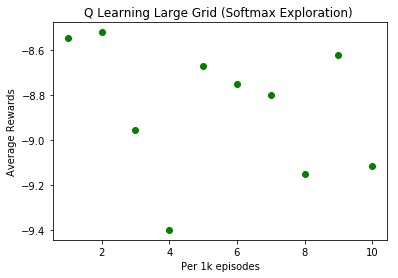

In [22]:
episodes=[1,2,3,4,5,6,7,8,9,10]
plt.plot(episodes,rewards_thousand_episodes,'go')
plt.ylabel('Average Rewards')
plt.xlabel('Per 1k episodes')
plt.title('Q Learning Large Grid (Softmax Exploration) ')
plt.savefig('E:/Machine Learning/HW4/QL_SE.png')

In [25]:
sum(Steps[-1000:])/1000

303.507